[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/dequantization.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/dequantization.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

-------------------
## Dequantization example

Normalizing flows are designed to model continuous variables, however they can be easily adapted to model discrete data as well. This is achieved by inserting a "dequantizer" into the bijector chain. We will demonstrate the use of a Uniform Dequantizer to model checkerboard data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pzflow import Flow
from pzflow.bijectors import Chain, ShiftBounds, RollingSplineCoupling, UniformDequantizer
from pzflow.examples import get_checkerboard_data

from optax import adam

PZFlow includes example data that is discrete in a checkerboard pattern:

In [2]:
data = get_checkerboard_data()
data

,x,y
0,2,0
1,3,1
2,1,1
3,1,3
4,3,3
...,...,...
99995,3,3
99996,0,2
99997,2,2
99998,0,2


In [51]:
import pandas as  pd

In [140]:
np.random.seed(0)
samples1 = np.abs(np.random.normal([2.5, 7.2], [1, 1], size=(20_000, 2))).astype(int)
samples2 = np.abs(np.random.normal([7.2, 3.2], [2, 2], size=(65_000, 2))).astype(int)
samples3 = np.abs(np.random.normal([2.1, 2.4], [1, 1], size=(15_000, 2))).astype(int)
samples = np.concatenate((samples1, samples2, samples3))

samples = np.clip(samples, 0, 9)

data = pd.DataFrame(samples, columns=("x", "y"))

In [141]:
data

,x,y
0,4,7
1,3,9
2,4,6
3,3,7
4,2,7
...,...,...
99995,2,1
99996,1,4
99997,0,2
99998,2,3


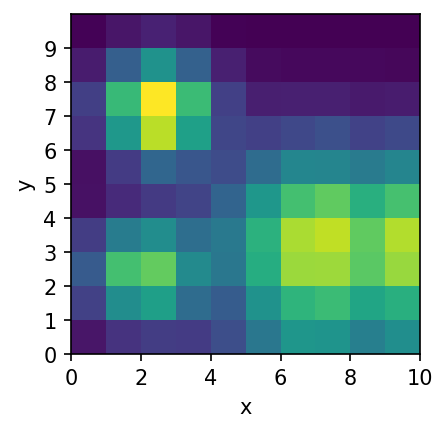

In [142]:
# Let's plot this distribution
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
R = 10
ax.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax.set(xlabel="x", ylabel="y", yticks=np.arange(R))
plt.show()

Let's see how the default normalizing flow performs with this data:

In [143]:
flow = Flow(data.columns)
losses = flow.train(data, verbose=True)
#losses = flow.train(data, epochs=35, optimizer=adam(1e-5), verbose=True)
#losses += flow.train(data, epochs=20, optimizer=adam(1e-6), verbose=True)

Training 100 epochs 
Loss:
(0) 4.8493
(1) 2.9534
(6) 2.5506
(11) 2.3200
(16) 3.9691
(21) 1.7155
(26) 2.6619
(31) 1.3618
(36) 1.8318
(41) 1.1798
(46) 3.2903
(51) 2.0116
(56) 0.6866
(61) 0.0556
(66) 0.2943
(71) -0.3578
(76) 0.7877
(81) 0.2823
(86) -0.2371
(91) -0.3916
(96) -1.0014
(100) 1.7795


First, let's plot the training loss:

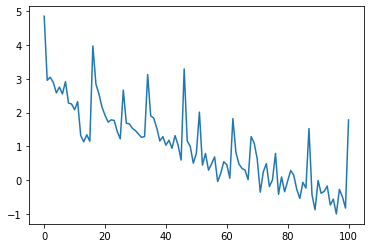

In [144]:
# plot the training losses
plt.plot(losses)

This doesn't look good...

Let's also plot some samples and compare to the truth data.

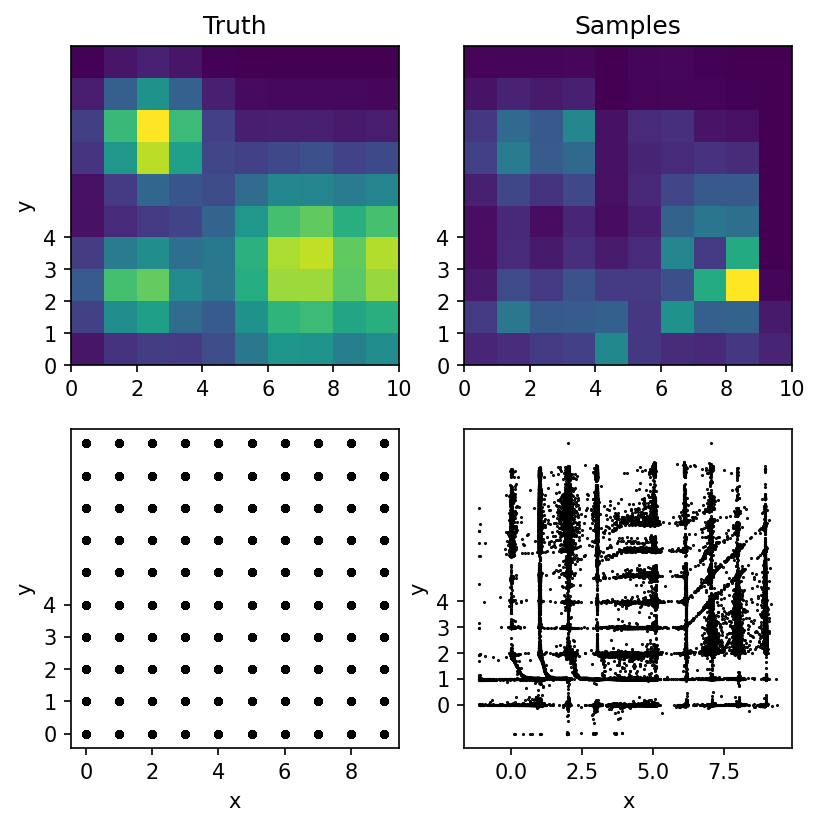

In [145]:
# plot some samples

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6.2, 6.2), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(ylabel="y", title="Truth", yticks=np.arange(5))
ax3.scatter(data["x"], data["y"], marker=".", c="k")
ax3.set(xlabel="x", ylabel="y", yticks=np.arange(5))

samples = flow.sample(data.shape[0])
ax2.hist2d(samples["x"], samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(title="Samples", yticks=np.arange(5))
ax4.scatter(samples["x"], samples["y"], marker=".", c="k", s=1)
ax4.set(xlabel="x", ylabel="y", yticks=np.arange(5))

plt.show()

Well that's weird... (I think the bottom right kind of looks like the head of a dog, with the CMB power spectrum on its cheek haha)

Clearly the default flow does a *really* bad job with discrete data!

We can do much better if we add a dequantizer to the bijector chain. 
The dequantizer will add uniform noise in the range (0, 1) to each variable, and thereby smooth out the distribution.
This allows the `RollingSplineCoupling` to perform better.

When sampling, everything acts in reverse, so the dequantizer will *quantize* the samples, resulting in a discrete distribution.

(Note the dequantizer isn't technically bijective, but that's okay)

In [150]:
# we build the exact same flow, except we add a dequantizer to the bijector chain
bijector = Chain(
    UniformDequantizer([0, 1]), # dequantize the data
    ShiftBounds(0, 10, B=5), # shift bounds of data from (0, 4) -> (-5, 5)
    RollingSplineCoupling(nlayers=2, B=5), # transform distribution
)

dq_flow = Flow(data.columns, bijector)

#dq_losses = dq_flow.train(data, epochs=50, optimizer=adam(1e-3), verbose=True)
#dq_losses = dq_flow.train(data, epochs=30, optimizer=adam(1e-5))
#dq_losses += dq_flow.train(data, epochs=200, optimizer=adam(1e-6))
dq_losses = dq_flow.train(data, verbose=True, optimizer=adam(1e-4))

Training 100 epochs 
Loss:
(0) 4.6678
(1) 3.3847
(6) 2.5783
(11) 3.0548
(16) 2.4242
(21) 2.9061
(26) 2.5543
(31) 1.1161
(36) 3.6363
(41) 1.4428
(46) 2.0146
(51) 2.3853
(56) 1.8829
(61) 1.0884
(66) 1.0035
(71) 2.3484
(76) 1.1558
(81) 1.0942
(86) 0.9255
(91) 0.9621
(96) 0.7448
(100) 1.1812


In [45]:
dq_losses += dq_flow.train(data, epochs=200, optimizer=adam(1e-6))

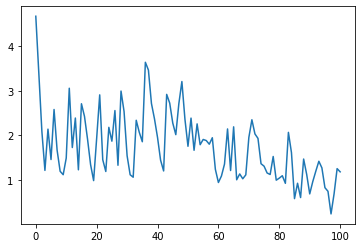

In [151]:
# plot the training losses
plt.plot(dq_losses)

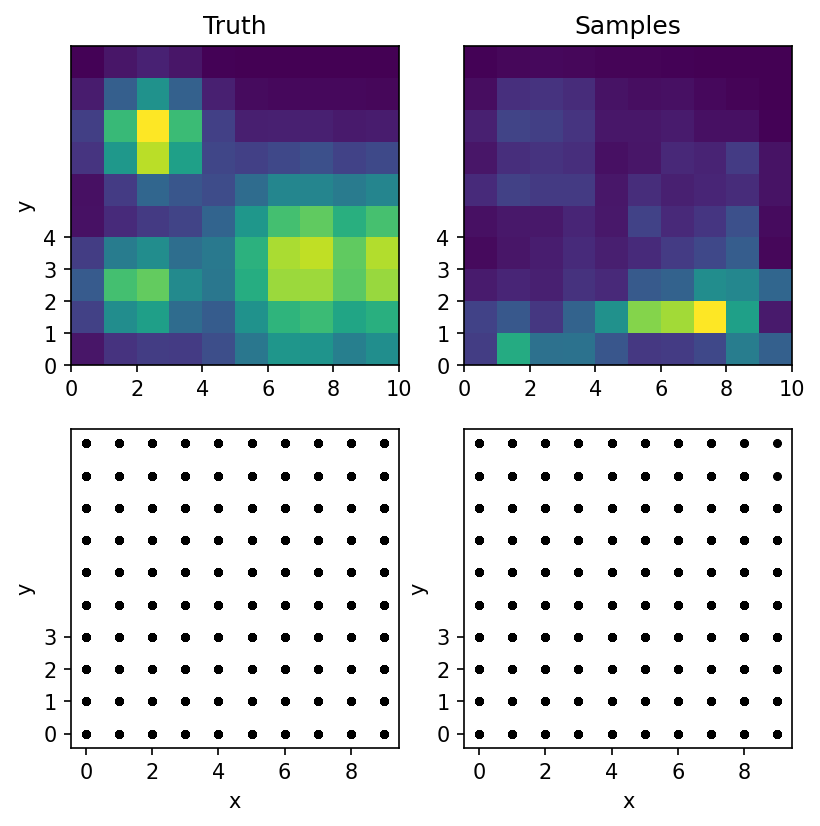

In [152]:
# plot some samples

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6.2, 6.2), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(ylabel="y", title="Truth", yticks=np.arange(5))
ax3.scatter(data["x"], data["y"], marker=".", c="k")
ax3.set(xlabel="x", ylabel="y", yticks=np.arange(4))

dq_samples = dq_flow.sample(data.shape[0])
ax2.hist2d(dq_samples["x"], dq_samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(title="Samples", yticks=np.arange(5))
ax4.scatter(dq_samples["x"], dq_samples["y"], marker=".", c="k")
ax4.set(xlabel="x", ylabel="y", yticks=np.arange(4))

plt.show()

We can see that this flow produces only discrete samples that lie on the grid, and that the distribution of samples closely matches that of the training data. In addition, the training was a lot easier - we could just do a single round of training with default settings, rather than needing to adjust the learning rate schedule. 

One more thing - You can model discrete and continuous variables side-by-side in the same normalizing flow! Just drop in `UniformDequantizer` with `column_idx` equal to the list of column indices corresponding to the discrete variables. 

For example, suppose we want to model data with column names ["a", "b", "c", "d"], and that "a" and "c" are continuous variables, while "b" and "d" are discrete variables. We can use a bijector like this:
```
bijector = Chain(
    UniformDequantizer(column_idx=[1, 3]),
    ...,
)
```